## Optimizing Persistence Diagram Transformer and Estimator Model Hyperparameters

In [1]:
from model_selection import TDAModelParameterSpace, TDAModelParameterSearchCV, TDAModelData

from sklearn import datasets
from ripser import Rips
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from persim.images import PersistenceImager
from persim.transformers import PersistencePairOrderer
from hyperopt import hp

import numpy as np
from pprint import pprint

#### Generate some toy data which we will classify using topological descriptors and other features

In [79]:
N = 200
N_per_class = int(N / 2)
N_in_class = 400

def noise(N, scale):
    return scale * np.random.random((N, 2))

def circle(N, scale, offset):
    return offset + scale * datasets.make_circles(n_samples=N, factor=0.4, noise=0.15)[0]
    
just_noise = [noise(N_in_class, 150) for _ in range(N_per_class)]

half = int(N_in_class / 2)
with_circle = [np.concatenate((circle(half, 50, 70), noise(half, 150)))
               for _ in range(N_per_class)]

data = []
data.extend(just_noise)
data.extend(with_circle)
data = np.array(data)

# Define labels
targets = np.zeros(N)
targets[N_per_class:] = 1
targets = np.array(targets)

# Shuffle data and labels
shuffler = np.random.permutation(N)

data = data[shuffler]
targets = targets[shuffler]

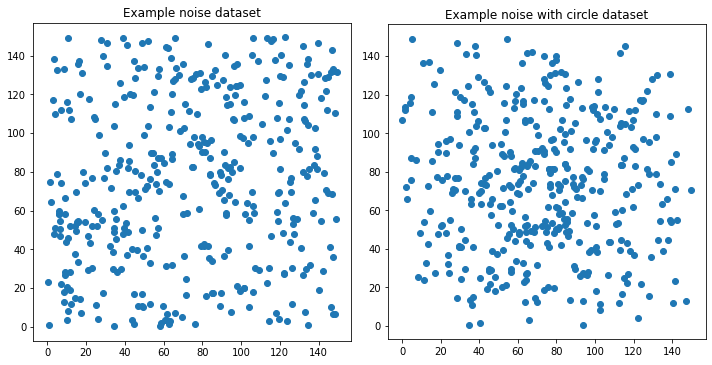

In [80]:
# Visualize the data
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10,5)

xs, ys = just_noise[0][:,0], just_noise[0][:,1]
axs[0].scatter(xs, ys)
axs[0].set_title("Example noise dataset")
axs[0].set_aspect('equal', 'box')

xs_, ys_ = with_circle[0][:,0], with_circle[0][:,1]
axs[1].scatter(xs_, ys_)
axs[1].set_title("Example noise with circle dataset")
axs[1].set_aspect('equal', 'box')

fig.tight_layout()

#### Compute persistence diagrams of Rips filtrations built on the toy data

In [81]:
rips = Rips(maxdim=1, coeff=2)

pers_dgms = {0: [], 1: []}
for datum in data:
    dgms = rips.fit_transform(datum)
    
    # drop infinitely persistent classes
    dgms[0] = dgms[0][dgms[0][:,1] < np.inf]
    dgms[1] = dgms[1][dgms[1][:,1] < np.inf]
    
    pers_dgms[0].append(dgms[0]) 
    pers_dgms[1].append(dgms[1])

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


#### Generate some non-topological, perhaps non-informative features of the data

In [82]:
features = np.empty((N, 5))
i=0
for datum in data:
    features[i,0] = datum.mean()
    features[i,1] = datum.std()
    features[i,2] = datum.max()
    features[i,3] = datum.min()
    features[i,4] = np.corrcoef(datum[:,0], datum[:,1])[1,1]
    i += 1

#### Store the data in a TDAModelData structure

In [84]:
tdata = TDAModelData(data=data, targets=targets, features=None, pers_dgms=pers_dgms)

#### Generate a very simple TDA model hyperparameter space with one estimator with default parameters and one transformer with several variable hyperparameters

In [85]:
mps = TDAModelParameterSpace()

mps.add_estimators(LogisticRegression)
mps.add_transformers({1: PersistencePairOrderer}, default_params=True)
mps.add_transformer_params('PersistencePairOrderer_1_1', {'order_by': mps.choice(['persistence', 'birth']),
                                                          'num_pairs': mps.choice([None, mps.quniform(1, 200, 1)])})
pprint(mps.space)

{'estimator_space': {'LogisticRegression_1': {'method': <class 'sklearn.linear_model._logistic.LogisticRegression'>,
                                              'params': {}}},
 'transformer_space': {1: {'PersistencePairOrderer_1_1': {'method': <class 'persim.transformers.PersistencePairOrderer'>,
                                                          'params': {'birth_only': False,
                                                                     'death_only': False,
                                                                     'descending': True,
                                                                     'n_jobs': None,
                                                                     'num_pairs': {'choice_se': {'options': [None,
                                                                                                             {'quniform_se': {'high': 200,
                                                                                           

In [94]:
# Make a valid scoring function for the classifier
scoring = make_scorer(roc_auc_score)

# Create a TDA model parameter optimizer over the transformer and estimator parameter space
mpscv = TDAModelParameterSearchCV(mps, scoring=scoring, method='tpe', cv=5, n_candidates=100, refit=False, n_jobs=-1)

# Perform a search over the transformer and estimator parameter space
mpscv.search(tdata)

100%|█████████████████████████████████████████████| 100/100 [00:04<00:00, 21.53trial/s, best loss: -0.9619719258620861]


In [114]:
# Results of the search are stored in the TDAModelParameterSearchCV().trials attribute, which is a hyperopt Trials() instance.
mpscv.trials

In [115]:
# Compare the performance of early candidates to later candidates
print('Average loss over first 10 parameter candidates: %g' %np.mean(mpscv.trials.losses()[:10]))
print('Average loss over first 10 parameter candidates: %g' %np.mean(mpscv.trials.losses()[-10:]))

Average loss over first 10 parameter candidates: -0.728413
Average loss over first 10 parameter candidates: -0.84114


In [120]:
# Access the best trial results and the best transformer attribute 
pprint(mpscv.trials.best_trial['result'])
print('\n', mpscv.best_transformer)

{'eval_time': 0.03390955924987793,
 'loss': -0.9619719258620861,
 'params': {'estimator_space': {'method': <class 'sklearn.linear_model._logistic.LogisticRegression'>,
                                'params': {}},
            'transformer_space': {1: {'method': <class 'persim.transformers.PersistencePairOrderer'>,
                                      'params': {'birth_only': False,
                                                 'death_only': False,
                                                 'descending': True,
                                                 'n_jobs': None,
                                                 'num_pairs': 65.0,
                                                 'order_by': 'birth',
                                                 'start_pair': 0}}}},
 'scores': array([1.        , 0.95      , 0.97727273, 0.95652174, 0.92606516]),
 'status': 'ok'}

 {1: PersistencePairOrderer(start_pair=0, num_pairs=65, birth_only=False, death_only=False, order_by=bi

#### Generate a more complicared TDA model hyperparameter space with two estimators and two transformers in each homological dimension

In [7]:
# First identify a reasonable range of the persistence plane over which to compute the persistence images for H_1 diagrams
pimgr = PersistenceImager()

pimgr.fit(pers_dgms[1])
imager_birth_range = (np.floor(pimgr.birth_range[0]), np.ceil(pimgr.birth_range[1]))
imager_pers_range = (np.floor(pimgr.pers_range[0]), np.ceil(pimgr.pers_range[1]))

In [8]:
mps = TDAModelParameterSpace()

# Add two diagrams transformers:
#  One generates persistence images, the other simply orders persistence pairs by their persistence
mps.add_transformers({1: [PersistenceImager, PersistenceImager]}, default_params=True)
pprint(mps.space)

{'estimator_space': {},
 'transformer_space': {1: {'PersistenceImager_1_1': {'method': <class 'persim.images.PersistenceImager'>,
                                                     'params': {'birth_range': (0.0,
                                                                                1.0),
                                                                'kernel': <function gaussian at 0x000001DC52247828>,
                                                                'kernel_params': {'sigma': [[1.0,
                                                                                             0.0],
                                                                                            [0.0,
                                                                                             1.0]]},
                                                                'pers_range': (0.0,
                                                                               1.0),
                 

In [9]:
from persim.images_weights import linear_ramp
# Add fixed and stochastic parameters to define the transformer hyperparameter spaces
mps.add_transformer_params('PersistenceImager_1_1', {'birth_range': imager_birth_range,
                                                     'pers_range': imager_pers_range,
                                                     'pixel_size': mps.uniform(0.1, 10),
                                                     'weight_params': {'n': mps.uniform(0,3)}
                                                     }
                          )

mps.add_transformer_params('PersistenceImager_1_2', {'birth_range': imager_birth_range,
                                                     'pers_range': imager_pers_range,
                                                     'pixel_size': mps.uniform(0.1, 10),
                                                     'weight': linear_ramp,
                                                     'weight_params': {'low': 0.0, 
                                                                       'high': 1.0, 
                                                                       'start': 0.0, 
                                                                       'end': mps.uniform(1,10)}
                                                     }
                          )
pprint(mps.space)

{'estimator_space': {},
 'transformer_space': {1: {'PersistenceImager_1_1': {'method': <class 'persim.images.PersistenceImager'>,
                                                     'params': {'birth_range': (0.0,
                                                                                33.0),
                                                                'kernel': <function gaussian at 0x000001DC52247828>,
                                                                'kernel_params': {'sigma': [[1.0,
                                                                                             0.0],
                                                                                            [0.0,
                                                                                             1.0]]},
                                                                'pers_range': (-1.0,
                                                                               22.0),
              

In [10]:
# Now define the estimator hyperparameter space
mps.add_estimators([LogisticRegression, SVC], default_params=True)
pprint(mps.space['estimator_space'])

{'LogisticRegression_1': {'method': <class 'sklearn.linear_model._logistic.LogisticRegression'>,
                          'params': {'C': 1.0,
                                     'class_weight': None,
                                     'dual': False,
                                     'fit_intercept': True,
                                     'intercept_scaling': 1,
                                     'l1_ratio': None,
                                     'max_iter': 100,
                                     'multi_class': 'auto',
                                     'n_jobs': None,
                                     'penalty': 'l2',
                                     'random_state': None,
                                     'solver': 'lbfgs',
                                     'tol': 0.0001,
                                     'verbose': 0,
                                     'warm_start': False}},
 'SVC_1': {'method': <class 'sklearn.svm._classes.SVC'>,
           'p

In [11]:
# Update parameters as desired and make some estimator hyperparameters stochastic expressions
mps.add_estimator_params('SVC_1', {'kernel': mps.choice(['rbf', 'linear', 'poly']),
                                   'degree': mps.quniform(1, 5, 1)})
mps.add_estimator_params('LogisticRegression_1', {'C': mps.loguniform(np.log(0.000001), np.log(1))
                                                 })
pprint(mps.space['estimator_space'])

{'LogisticRegression_1': {'method': <class 'sklearn.linear_model._logistic.LogisticRegression'>,
                          'params': {'C': {'loguniform_se': {'high': 0.0,
                                                             'low': -13.815510557964274}},
                                     'class_weight': None,
                                     'dual': False,
                                     'fit_intercept': True,
                                     'intercept_scaling': 1,
                                     'l1_ratio': None,
                                     'max_iter': 100,
                                     'multi_class': 'auto',
                                     'n_jobs': None,
                                     'penalty': 'l2',
                                     'random_state': None,
                                     'solver': 'lbfgs',
                                     'tol': 0.0001,
                                     'verbose': 0,
            

#### Perform Bayesian hyperparameter optimization using cross-validation of ROC-AUC scores

In [12]:
from sklearn.metrics import make_scorer, roc_auc_score

scoring = make_scorer(roc_auc_score)

mpscv = TDAModelParameterSearchCV(mps, scoring=scoring, method='tpe', n_candidates=10, refit=False, n_jobs=-1)

mpscv.search(tdata)

100%|██████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/trial, best loss: -1.0]


In [13]:
# Fit the best found estimator to the training data using the best found diagram transformer (automatic if refit = True)
mpscv.fit(tdata)

In [14]:
# Access the best transformer, best estimator, and the best trial results
pprint(mpscv.best_transformer)
print('\n')
pprint(mpscv.best_estimator)
print('\n')
pprint(mpscv.trials.best_trial['result'])

{1: PersistenceImager(birth_range=(0.0, 33.0), pers_range=(-1.0, 22.0), pixel_size=3.1836216715623533, weight=linear_ramp, weight_params={'end': 7.921217436307092, 'high': 1.0, 'low': 0.0, 'start': 0.0}, kernel=gaussian, kernel_params={'sigma': ((1.0, 0.0), (0.0, 1.0))})}


SVC(degree=4.0, kernel='linear')


{'eval_time': 4.534724950790405,
 'loss': -1.0,
 'params': {'estimator_space': {'method': <class 'sklearn.svm._classes.SVC'>,
                                'params': {'C': 1.0,
                                           'break_ties': False,
                                           'cache_size': 200,
                                           'class_weight': None,
                                           'coef0': 0.0,
                                           'decision_function_shape': 'ovr',
                                           'degree': 4.0,
                                           'gamma': 'scale',
                                           'kernel': 'linear',
    